# MobileNet with fine tuning 20 layers and learning Rate


In this run for the MobileNet, we froze all layers but the last 20 and added two dense layers after the conv_base.
We descreased also the Learing Rate to 1e-4

Results>

Best Epoch: 72

test acc: 0.86266

test loss: 5.11339

f1_score: 0.86519

Precision: 0.85560

Recall: 0.875

ROC AUC: 0.86366

---Training:  seconds --- 18996,7 s

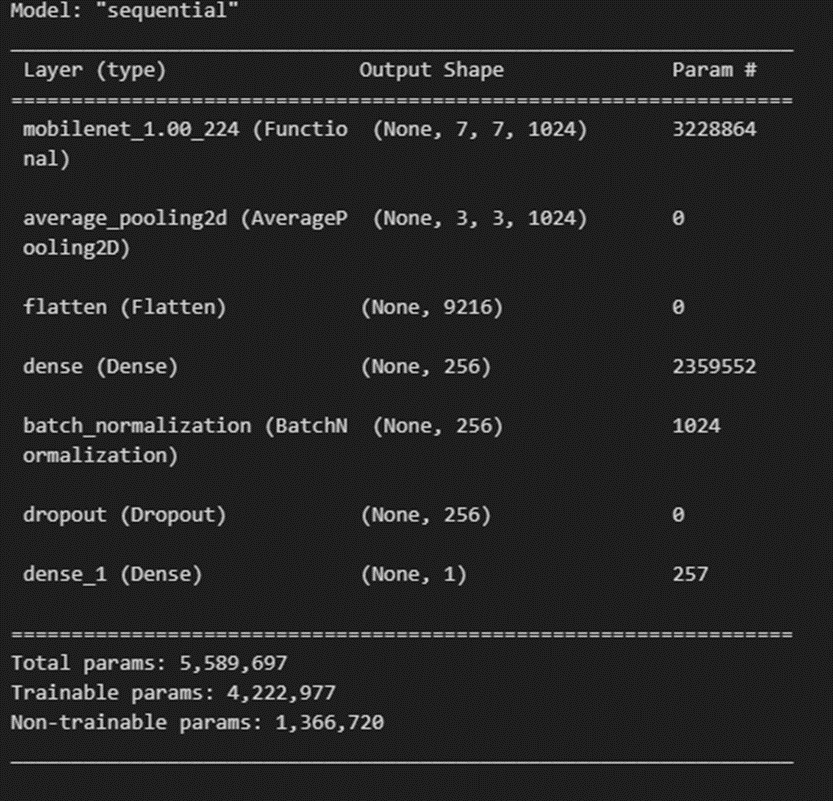

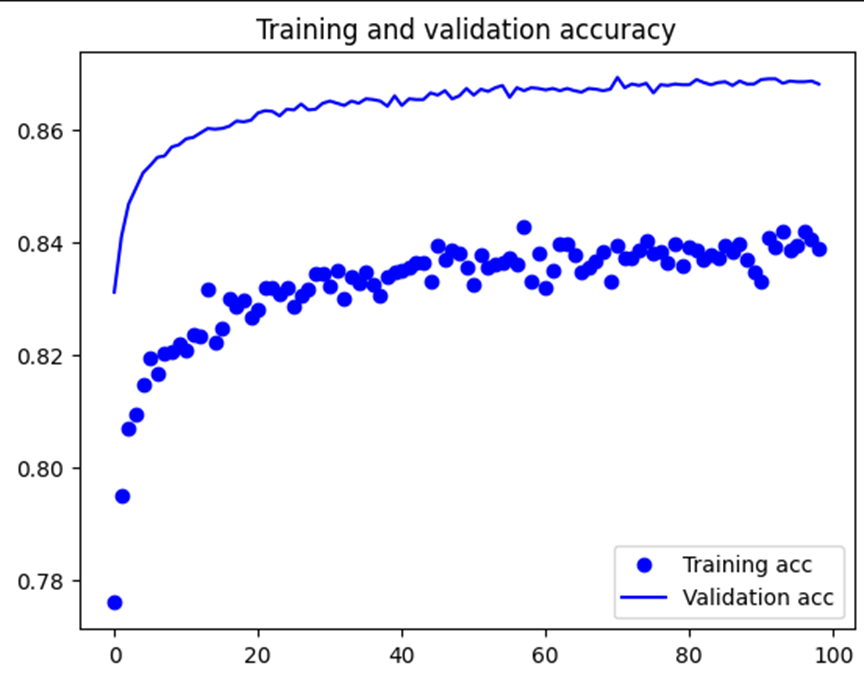

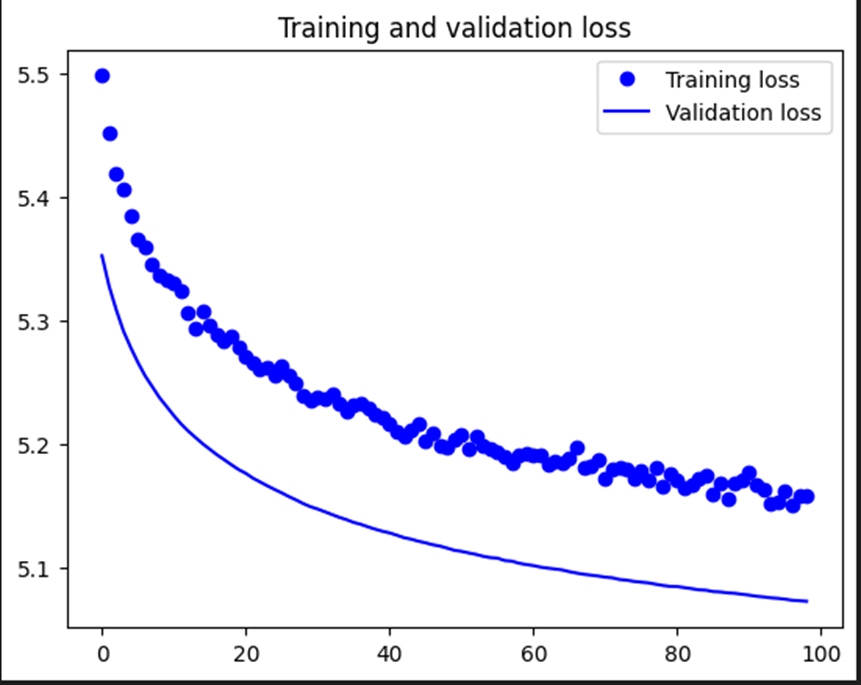

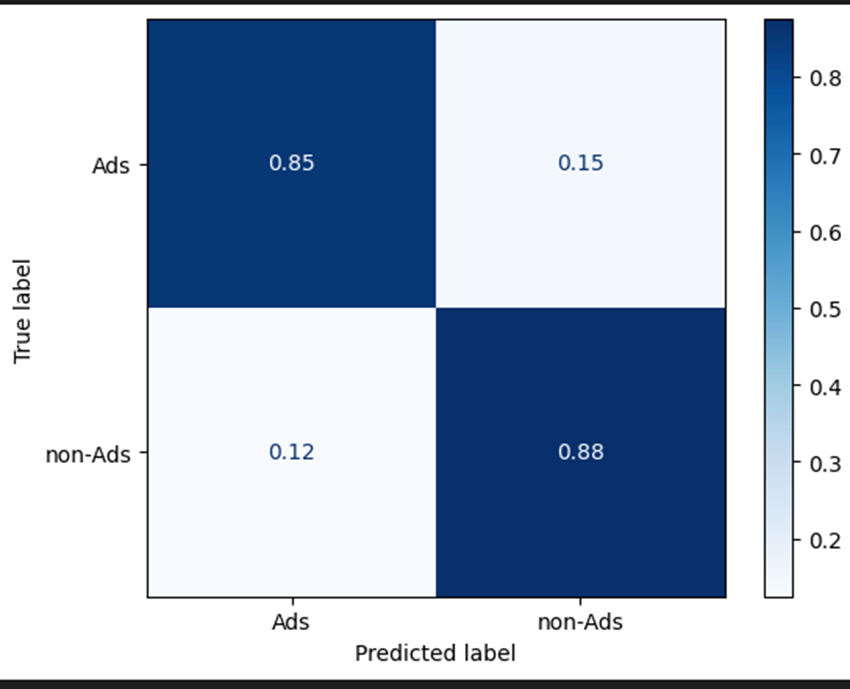

In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install torchvision

In [4]:

#!pip list
import torch

In [5]:
#!nvidia-smi

In [6]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [7]:
# add headings with ##(space) on the markdowns

In [8]:
#!pip install tensorflor keras

In [9]:
import tensorflow as tf
import os

In [10]:
!nvidia-smi

Mon Jun 24 08:13:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   50C    P8              16W / 125W |    642MiB /  6144MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
#! nvidia-smi

In [14]:
#!pip install opencv-python

## Imports

In [15]:
import tensorflow as tf
import os
import cv2
import imghdr

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
class TrainingConfig:
    BATCH_SIZE:       int   = 64
    EPOCHS:           int   = 100
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.5
    LAYERS_FINE_TUNE: int   = 20
    EPSILON:          float = 1e-07
    MOMENTUM:         float = 0.9   
    WEIGHT_DECAY:     float = 0.0005 

# Split Data

In [18]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Random_Split"

In [19]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [20]:
train_Ads_dir = os.path.join(train_dir, 'Ads')
train_sample_dir = os.path.join(train_dir, 'Sample')
train_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\train\\Ads'

In [21]:
validation_Ads_dir = os.path.join(validation_dir, 'Ads')
validation_sample_dir = os.path.join(validation_dir, 'Sample')
validation_Ads_dir


'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\validation\\Ads'

In [22]:
test_Ads_dir = os.path.join(test_dir, 'Ads')
test_sample_dir = os.path.join(test_dir, 'Sample')
test_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\test\\Ads'

In [23]:
print('total training Ads images:', len(os.listdir(train_Ads_dir)))

total training Ads images: 10500


In [24]:
print('total training sample images:', len(os.listdir(train_sample_dir)))

total training sample images: 10500


In [25]:
print('total validation Ads images:', len(os.listdir(validation_Ads_dir)))

total validation Ads images: 3650


In [26]:
print('total validation sample images:', len(os.listdir(validation_sample_dir)))

total validation sample images: 3950


In [27]:
print('total test Ads images:', len(os.listdir(test_Ads_dir)))

total test Ads images: 3000


In [28]:
print('total test sample images:', len(os.listdir(test_sample_dir)))

total test sample images: 3000


## Using data augmentation/ datagen

In [29]:
import numpy as np
from PIL import ImageEnhance
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.utils import img_to_array, array_to_img,  load_img

In [30]:
# Custom preprocessing function for color augmentation
def color_jitter(image):
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.4, 1.6)) # from -60% to +60%
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.4, 1.6))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.4, 1.6))
    return image

In [31]:
# Custom preprocessing function for ImageDataGenerator
def custom_preprocessing_function(image):
    # Convert array to PIL image
    image = array_to_img(image)
    # Apply color jitter
    image = color_jitter(image)
    # Convert PIL image back to array
    image = img_to_array(image)
    return image

In [32]:
from keras.preprocessing.image import ImageDataGenerator
## with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing_function)

# train_datagen = ImageDataGenerator(
#     rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 7600 images belonging to 2 classes.


## Pretrained Model Inception

In [33]:
import keras
from keras.models import load_model


# Appling a Pre-trained CNN on our Dataset for comparison

The MobileNet model




In [34]:
from keras.applications import MobileNet

conv_base = MobileNet(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

In [35]:
conv_base.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

We will add a dense layer after our conv_base NN

In [36]:
from keras import models
from keras import layers
from keras.regularizers import l2, l1
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D

modelPreTMob = models.Sequential()
modelPreTMob.add(conv_base)

modelPreTMob.add(layers.AveragePooling2D())
modelPreTMob.add(layers.Flatten())
modelPreTMob.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
modelPreTMob.add(BatchNormalization())
modelPreTMob.add(layers.Dropout(TrainingConfig.DROPOUT))
modelPreTMob.add(layers.Dense(1, activation='sigmoid'))

In [38]:
modelPreTMob.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1024)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 256)               2359552   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                        

In [39]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv1 True
2 conv1_bn True
3 conv1_relu True
4 conv_dw_1 True
5 conv_dw_1_bn True
6 conv_dw_1_relu True
7 conv_pw_1 True
8 conv_pw_1_bn True
9 conv_pw_1_relu True
10 conv_pad_2 True
11 conv_dw_2 True
12 conv_dw_2_bn True
13 conv_dw_2_relu True
14 conv_pw_2 True
15 conv_pw_2_bn True
16 conv_pw_2_relu True
17 conv_dw_3 True
18 conv_dw_3_bn True
19 conv_dw_3_relu True
20 conv_pw_3 True
21 conv_pw_3_bn True
22 conv_pw_3_relu True
23 conv_pad_4 True
24 conv_dw_4 True
25 conv_dw_4_bn True
26 conv_dw_4_relu True
27 conv_pw_4 True
28 conv_pw_4_bn True
29 conv_pw_4_relu True
30 conv_dw_5 True
31 conv_dw_5_bn True
32 conv_dw_5_relu True
33 conv_pw_5 True
34 conv_pw_5_bn True
35 conv_pw_5_relu True
36 conv_pad_6 True
37 conv_dw_6 True
38 conv_dw_6_bn True
39 conv_dw_6_relu True
40 conv_pw_6 True
41 conv_pw_6_bn True
42 conv_pw_6_relu True
43 conv_dw_7 True
44 conv_dw_7_bn True
45 conv_dw_7_relu True
46 conv_pw_7 True
47 conv_pw_7_bn True
48 conv_pw_7_relu True
49 conv_dw_8 True
5

In [40]:
# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(conv_base.layers)

In [41]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreTMob.trainable_weights))

This is the number of trainable weights before freezing the conv base: 87


In [42]:
# Freeze the initial layers in the convolutional base.
for model_layer in conv_base.layers[:num_layers - num_layers_fine_tune]:
    #print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

In [43]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1 False
2 conv1_bn False
3 conv1_relu False
4 conv_dw_1 False
5 conv_dw_1_bn False
6 conv_dw_1_relu False
7 conv_pw_1 False
8 conv_pw_1_bn False
9 conv_pw_1_relu False
10 conv_pad_2 False
11 conv_dw_2 False
12 conv_dw_2_bn False
13 conv_dw_2_relu False
14 conv_pw_2 False
15 conv_pw_2_bn False
16 conv_pw_2_relu False
17 conv_dw_3 False
18 conv_dw_3_bn False
19 conv_dw_3_relu False
20 conv_pw_3 False
21 conv_pw_3_bn False
22 conv_pw_3_relu False
23 conv_pad_4 False
24 conv_dw_4 False
25 conv_dw_4_bn False
26 conv_dw_4_relu False
27 conv_pw_4 False
28 conv_pw_4_bn False
29 conv_pw_4_relu False
30 conv_dw_5 False
31 conv_dw_5_bn False
32 conv_dw_5_relu False
33 conv_pw_5 False
34 conv_pw_5_bn False
35 conv_pw_5_relu False
36 conv_pad_6 False
37 conv_dw_6 False
38 conv_dw_6_bn False
39 conv_dw_6_relu False
40 conv_pw_6 False
41 conv_pw_6_bn False
42 conv_pw_6_relu False
43 conv_dw_7 False
44 conv_dw_7_bn False
45 conv_dw_7_relu False
46 conv_pw_7 False
47 conv_pw_7_bn 

In [43]:
#conv_base.trainable = False

In [44]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(modelPreTMob.trainable_weights))

This is the number of trainable weights after freezing the conv base: 24


In [45]:
modelPreTMob.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1024)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 256)               2359552   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                        

In [46]:
from keras import optimizers
adagrad = optimizers.Adagrad(learning_rate=TrainingConfig.LEARNING_RATE, initial_accumulator_value=0.1, epsilon=TrainingConfig.EPSILON, decay =TrainingConfig.WEIGHT_DECAY)

In [47]:
modelPreTMob.compile(optimizer= adagrad, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])# Adagrad, adam

In [48]:
# add checkpoint to store the model on the best epoch for Val acc.
checkpoint_filepath = r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelMobileNet_FT20-{epoch:02d}-{val_accuracy:.4f}.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [49]:
print(TrainingConfig.EPOCHS)

100


In [50]:
import time
start_time = time.time()

In [51]:
histPreT = modelPreTMob.fit(train_generator, epochs = TrainingConfig.EPOCHS, validation_data=validation_generator, callbacks=[model_checkpoint_callback]) 

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 5.6678 - accuracy: 0.6847
Epoch 1: val_accuracy improved from -inf to 0.81316, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelMobileNet_FT20-01-0.8132.keras
329/329 [==============================] - 227s 674ms/step - loss: 5.6678 - accuracy: 0.6847 - val_loss: 5.3932 - val_accuracy: 0.8132
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 5.4977 - accuracy: 0.7760
Epoch 2: val_accuracy improved from 0.81316 to 0.83118, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelMobileNet_FT20-02-0.8312.keras
329/329 [==============================] - 197s 599ms/step - loss: 5.4977 - accuracy: 0.7760 - val_loss: 5.3522 - val_accuracy: 0.8312
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 5.4511 - accuracy: 0.7950
Epoch 3: val_accuracy improved from 0.83118 to 0.84105, saving model to C:\Users\YannisPC\PycharmProjects\

In [52]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 18996.756459236145 seconds ---


In [53]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [54]:
os.path.join(Current_dir, 'History')

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History'

In [55]:
import pickle
with open(r'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History\\HistoryDict_MobileNet_FT20', 'wb') as file_pi:
    pickle.dump(histPreT.history, file_pi)

In [56]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 72


In [57]:
START_PLOT_FROM_EPOCH= 1

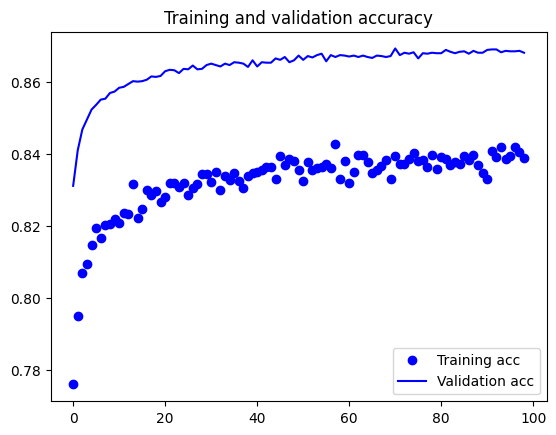

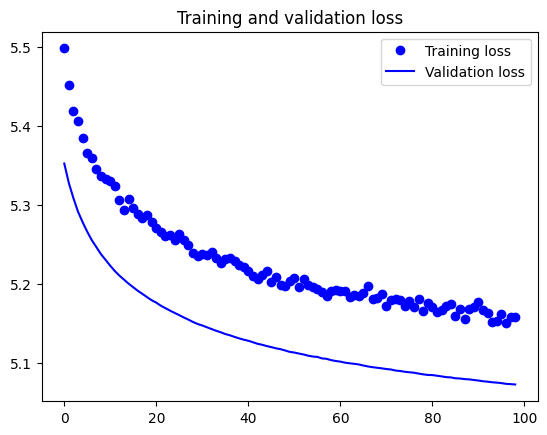

In [58]:
acc = histPreT.history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc = histPreT.history['val_accuracy'][START_PLOT_FROM_EPOCH:]
loss = histPreT.history['loss'][START_PLOT_FROM_EPOCH:]
val_loss = histPreT.history['val_loss'][START_PLOT_FROM_EPOCH:]

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [59]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 72


# Loading best epoch in our model using the checkpoints

In [60]:
model_dir= r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints' # C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints

In [61]:
best_val_accuracy = max(val_acc_per_epoch)
best_model_file = f'model-{best_epoch:02d}-{best_val_accuracy:.4f}.keras'

print(f'Best model file: {best_model_file}')

Best model file: model-72-0.8693.keras


In [62]:
os.chdir(model_dir)
Current_dir = os.getcwd()
Current_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints'

In [63]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(model_dir) if isfile(join(model_dir, f))]
onlyfiles

['checkpoints.lnk',
 'modelMobileNet_FT20-01-0.8132.keras',
 'modelMobileNet_FT20-02-0.8312.keras',
 'modelMobileNet_FT20-03-0.8411.keras',
 'modelMobileNet_FT20-04-0.8468.keras',
 'modelMobileNet_FT20-05-0.8496.keras',
 'modelMobileNet_FT20-06-0.8524.keras',
 'modelMobileNet_FT20-07-0.8537.keras',
 'modelMobileNet_FT20-08-0.8551.keras',
 'modelMobileNet_FT20-09-0.8554.keras',
 'modelMobileNet_FT20-10-0.8570.keras',
 'modelMobileNet_FT20-11-0.8574.keras',
 'modelMobileNet_FT20-12-0.8584.keras',
 'modelMobileNet_FT20-13-0.8587.keras',
 'modelMobileNet_FT20-14-0.8595.keras',
 'modelMobileNet_FT20-15-0.8603.keras',
 'modelMobileNet_FT20-18-0.8607.keras',
 'modelMobileNet_FT20-19-0.8616.keras',
 'modelMobileNet_FT20-21-0.8617.keras',
 'modelMobileNet_FT20-22-0.8630.keras',
 'modelMobileNet_FT20-23-0.8634.keras',
 'modelMobileNet_FT20-26-0.8637.keras',
 'modelMobileNet_FT20-28-0.8646.keras',
 'modelMobileNet_FT20-31-0.8647.keras',
 'modelMobileNet_FT20-32-0.8651.keras',
 'modelMobileNet_FT2

In [65]:
from keras.models import load_model
#loaded_model = load_model(os.path.join('checkpoints',best_model_file))
loaded_model = load_model('modelMobileNet_FT20-72-0.8693.keras') 
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1024)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 256)               2359552   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                        

## Evaluate

In [66]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [67]:
start_time = time.time()

In [68]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.EPOCHS,
        class_mode='binary')

test_loss, test_acc = loaded_model.evaluate(test_generator, steps=len(test_generator))  # steps_per_epoch * epochs
print('test acc:', test_acc)
print('test loss:', test_loss)


Found 6000 images belonging to 2 classes.
60/60 [==============================] - 14s 215ms/step - loss: 5.1134 - accuracy: 0.8627
test acc: 0.862666666507721
test loss: 5.113394260406494


In [69]:
print("--- %s Training set > seconds ---" % (time.time() - start_time))

--- 14.56051516532898 Training set > seconds ---


In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to collect true labels and predictions
true_labels = []
predicted_labels = []

In [71]:
for _ in range(len(test_generator)):
    X, y = next(test_generator)

    yhat = modelPreTMob.predict(X)
    
    y_true_batch = y # Labels
    
    # Convert probabilities to class labels using a threshold of 0.5
    y_pred_batch = (yhat > 0.5).astype(int)

    # Append the true labels and predictions for this batch to the lists
    true_labels.extend(y_true_batch)
    predicted_labels.extend(y_pred_batch)

    if len(true_labels) >= test_generator.n:
        break

4/4 [==============================] - 0s 28ms/step


In [72]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [73]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[2557,  443],
       [ 375, 2625]], dtype=int64)

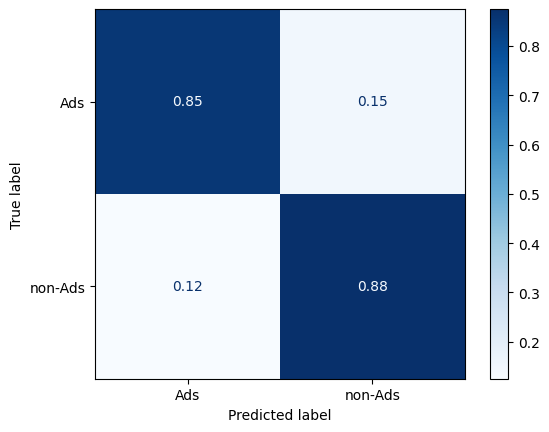

In [74]:
# Plot the confusion matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm_sum.astype(float), display_labels=['Ads', 'non-Ads'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [75]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [76]:

f1_score(true_labels, predicted_labels)

0.8651944627554383

In [77]:
# precision tp / (tp + fp)
precision = precision_score(true_labels, predicted_labels)
precision

0.855606258148631

In [78]:
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predicted_labels)
recall

0.875

In [79]:
# ROC AUC
auc = roc_auc_score(true_labels, predicted_labels)
print('ROC AUC: %f' % auc)

ROC AUC: 0.863667
